# Data Preprocessing

In [1]:
!pip -q install -U datasets huggingface_hub
!pip -q install -U "transformers==4.44.2" "peft==0.13.0"

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 494.8/494.8 kB 12.9 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 561.5/561.5 kB 23.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 12.8 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 2.8.0 requires google-cloud-bigquery-storage<3.0.0,>=2.30.0, which is not installed.
cesium 0.12.4 requires numpy<3.0,>=2.0, but you have numpy 1.26.4 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cuda-cupti-cu12 12.5.82 which is incompatible.
torch 2.6.0+cu124 requ

In [ ]:
from huggingface_hub import login
from getpass import getpass

login(token=getpass("🔑 Enter your HF write token: "))

🔑 Enter your HF write token:  ········


In [3]:
import numpy as np
from datasets import load_dataset, DatasetDict
from transformers import AutoTokenizer

In [5]:
import re
import unicodedata
import numpy as np
from datasets import load_dataset, DatasetDict
from transformers import AutoTokenizer


_URL_RE   = re.compile(r"""(?i)\b((?:https?://|www\.)\S+)\b""")
_EMAIL_RE = re.compile(r"""(?i)\b[a-z0-9._%+-]+@[a-z0-9.-]+\.[a-z]{2,}\b""")
_USER_RE  = re.compile(r"""(?i)(?<!\w)@[\w_]+""")
_HASH_RE  = re.compile(r"""(?<!\w)#(\w+)\b""")  # keep the token text, drop '#'
_WS_RE    = re.compile(r"\s+")

def normalize_text_roberta(
    text: str,
    *,
    replace_urls: bool = True,
    replace_emails: bool = True,
    normalize_user_mentions: bool = True,
    detag_hashtags: bool = True,
    collapse_whitespace: bool = True,
    remove_control_chars: bool = True
) -> str:
    if not isinstance(text, str):
        text = "" if text is None else str(text)

    # Unicode normalize
    t = unicodedata.normalize("NFKC", text)

    # Line breaks -> space
    t = t.replace("\r", " ").replace("\n", " ")

    # Replace patterns
    if replace_urls:
        t = _URL_RE.sub("<url>", t)
    if replace_emails:
        t = _EMAIL_RE.sub("<email>", t)
    if normalize_user_mentions:
        t = _USER_RE.sub("@USER", t)
    if detag_hashtags:
        t = _HASH_RE.sub(r"\1", t)   # keep hashtag word, drop '#'

    if remove_control_chars:
        t = "".join(ch for ch in t if ch.isprintable() or ch in (" ", "\t"))

    # Collapse whitespace and trim
    if collapse_whitespace:
        t = _WS_RE.sub(" ", t).strip()

    return t


def make_preprocess_fn(
    tokenizer, max_len=256, label_cols=("Emotion", "EmotionalPolarity", "Empathy"),
    text_cleaner=normalize_text_roberta
):
    def _preprocess(batch):
        # Apply cleaner to each text in the batch
        cleaned_texts = [text_cleaner(t) for t in batch["text"]]

        enc = tokenizer(
            cleaned_texts,
            truncation=True,
            padding="max_length",
            max_length=max_len
        )
        labels = np.stack([batch[c] for c in label_cols], axis=1).astype("float32")
        enc["labels"] = labels
        return enc
    return _preprocess


def load_and_tokenize_dataset(
    dataset_id: str,
    model_name: str = "roberta-base",
    max_len: int = 256,
    val_ratio: float = 0.1,
    seed: int = 42,
    label_cols=("Emotion", "EmotionalPolarity", "Empathy"),
    drop_original_cols: bool = True,
    return_tokenizer: bool = False,
    text_cleaner=normalize_text_roberta
):
    ds = load_dataset(dataset_id)

    if "validation" not in ds:
        split = ds["train"].train_test_split(test_size=val_ratio, seed=seed, shuffle=True)
        ds = DatasetDict({"train": split["train"], "validation": split["test"]})

    tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=True)
    preprocess = make_preprocess_fn(
        tokenizer, max_len=max_len, label_cols=label_cols, text_cleaner=text_cleaner
    )

    remove_cols = ds["train"].column_names if drop_original_cols else None
    ds_tok = ds.map(preprocess, batched=True, remove_columns=remove_cols).with_format("torch")

    return (ds, ds_tok, tokenizer) if return_tokenizer else (ds, ds_tok)


ds, ds_tok, tok = load_and_tokenize_dataset(
    dataset_id="miladsolo/wassa-conv-turn-empathy",
    model_name="roberta-base",
    max_len=256,
    val_ratio=0.1,
    seed=42,
    return_tokenizer=True,
)

print(ds_tok)
print({k: v.shape for k, v in ds_tok["train"][0].items()})


Map:   0%|          | 0/10940 [00:00<?, ? examples/s]

Map:   0%|          | 0/1216 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 10940
    })
    validation: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 1216
    })
})
{'input_ids': torch.Size([256]), 'attention_mask': torch.Size([256]), 'labels': torch.Size([3])}


In [7]:
import numpy as np
import torch


def _to_list(x):
    if isinstance(x, torch.Tensor):
        return x.detach().cpu().tolist()
    if isinstance(x, np.ndarray):
        return x.tolist()
    return x if isinstance(x, list) else list(x)


def show_example(i, ds_raw, ds_tok, tokenizer, max_len=256, preview=40):
    raw = ds_raw["train"][i]
    tokd = ds_tok["train"][i]

    text = raw["text"]
    labels = [
        float(raw["Emotion"]),
        float(raw["EmotionalPolarity"]),
        float(raw["Empathy"]),
    ]

    input_ids = _to_list(tokd["input_ids"])
    attn_mask = _to_list(tokd["attention_mask"])
    tokens = tokenizer.convert_ids_to_tokens(input_ids)

    seq_len = int(sum(attn_mask))
    truncated = seq_len == max_len

    print(f"\n=== Example {i} ===")
    print("Raw text:\n", text)
    print("Labels [Emotion, Polarity, Empathy]:", labels)
    print(
        f"\nTokenized length (non-pad): {seq_len} | Truncated_to_{max_len}? {truncated}"
    )

    print("\nFirst tokens:")
    print(tokens[:preview])
    print("\nFirst input_ids:")
    print(input_ids[:preview])
    print("\nFirst attention_mask:")
    print(attn_mask[:preview])

    # Decode only non-pad positions; skip special tokens for readability
    decoded = tokenizer.decode(
        [tid for tid, m in zip(input_ids, attn_mask) if m == 1],
        skip_special_tokens=True,
    )
    print("\nDecoded (no special tokens):")
    print(decoded[:400])


for idx in [0, 1]:
    show_example(idx, ds, ds_tok, tok, max_len=256, preview=40)



=== Example 0 ===
Raw text:
 He didn't have any was his main problem and he couldn't get on medicaid
Labels [Emotion, Polarity, Empathy]: [2.6666998863220215, 2.0, 2.3333001136779785]

Tokenized length (non-pad): 19 | Truncated_to_256? False

First tokens:
['<s>', 'He', 'Ġdidn', "'t", 'Ġhave', 'Ġany', 'Ġwas', 'Ġhis', 'Ġmain', 'Ġproblem', 'Ġand', 'Ġhe', 'Ġcouldn', "'t", 'Ġget', 'Ġon', 'Ġmedic', 'aid', '</s>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']

First input_ids:
[0, 894, 399, 75, 33, 143, 21, 39, 1049, 936, 8, 37, 1705, 75, 120, 15, 26467, 5526, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

First attention_mask:
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

Decoded (no special tokens):
He didn't have any was his main problem and he couldn't

# Model

In [8]:
import torch

from transformers import AutoConfig, AutoModelForSequenceClassification, AutoTokenizer
from peft import LoraConfig, TaskType, get_peft_model

In [13]:
def build_lora_roberta_regressor(
    model_name: str = "roberta-base",
    num_labels: int = 3,
    r: int = 32,
    lora_alpha: int = 32,
    lora_dropout: float = 0.05,
    target_modules = ("query", "key", "value", "output.dense", "intermediate.dense"),
    bias: str = "none",
):

    cfg = AutoConfig.from_pretrained(
        model_name,
        num_labels=num_labels,
        problem_type="regression",
        id2label={0: "Emotion", 1: "EmotionalPolarity", 2: "Empathy"},
        label2id={"Emotion": 0, "EmotionalPolarity": 1, "Empathy": 2},
    )
    base = AutoModelForSequenceClassification.from_pretrained(model_name, config=cfg)

    lora_cfg = LoraConfig(
        task_type=TaskType.SEQ_CLS,
        r=r,
        lora_alpha=lora_alpha,
        lora_dropout=lora_dropout,
        target_modules=list(target_modules),
        bias=bias,
    )
    model = get_peft_model(base, lora_cfg)
    return model

model = build_lora_roberta_regressor(model_name="roberta-base")
model.print_trainable_parameters()

tok = AutoTokenizer.from_pretrained("roberta-base")
ex = tok("this is a test", return_tensors="pt")
with torch.no_grad():
    out = model(**ex)
print(out.logits.shape)  # should be [1, 3]
print(out.logits)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


trainable params: 5,901,315 || all params: 130,549,254 || trainable%: 4.5204
torch.Size([1, 3])
tensor([[ 0.1554,  0.0004, -0.0371]])


# Trainer

In [21]:
import numpy as np
import torch
import torch.nn.functional as F
from torch.optim import AdamW
from torch.optim.lr_scheduler import ReduceLROnPlateau
from transformers import Trainer, TrainingArguments, DataCollatorWithPadding, TrainerCallback

In [22]:
def _pearson(x: np.ndarray, y: np.ndarray) -> float:
    x = x.astype(np.float64)
    y = y.astype(np.float64)
    x_c = x - x.mean()
    y_c = y - y.mean()
    denom = np.sqrt((x_c**2).sum()) * np.sqrt((y_c**2).sum())
    return 0.0 if denom == 0.0 else float((x_c * y_c).sum() / denom)


class HuberTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        preds = outputs.logits
        # ensure same dtype/device
        labels = labels.to(preds.dtype)
        loss = F.huber_loss(preds, labels, delta=0.5, reduction="mean")
        return (loss, outputs) if return_outputs else loss


def compute_metrics(eval_pred):
    preds, labels = eval_pred
    if isinstance(preds, (tuple, list)):
        preds = preds[0]
    preds = preds.astype("float32")
    labels = labels.astype("float32")
    mae = np.mean(np.abs(preds - labels), axis=0)
    r = [_pearson(preds[:, i], labels[:, i]) for i in range(labels.shape[1])]
    return {
        "mae_emotion": float(mae[0]),
        "mae_polarity": float(mae[1]),
        "mae_empathy": float(mae[2]),
        "mae_mean": float(np.mean(mae)),
        "r_emotion": r[0],
        "r_polarity": r[1],
        "r_empathy": r[2],
        "r_mean": float(np.mean(r)),
    }


class PlateauLRSchedulerCallback(TrainerCallback):
    def __init__(self, scheduler, monitor="eval_r_mean"):
        self.scheduler = scheduler
        self.monitor = monitor

    def on_evaluate(self, args, state, control, metrics, **kwargs):
        metric = metrics.get(self.monitor)
        if metric is not None:
            self.scheduler.step(metric)
            lr = self.scheduler.optimizer.param_groups[0]["lr"]
            print(f"[plateau] {self.monitor}={metric:.6f} -> lr={lr:.3e}")


plateau_sched = ReduceLROnPlateau(
    AdamW(model.parameters(), lr=1e-2, weight_decay=0.05),
    mode="max",
    factor=0.5,
    patience=20,
    threshold=1e-4,
    threshold_mode="abs",
    cooldown=0,
    min_lr=1e-6,
    verbose=True,
)
optimizer = plateau_sched.optimizer

args = TrainingArguments(
    output_dir="out_roberta_lora_wassa",
    learning_rate=1e-3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=8,
    gradient_accumulation_steps=4,  # effective batch = 64
    num_train_epochs=5,
    weight_decay=0.01,
    logging_strategy="steps",
    evaluation_strategy="steps",
    eval_steps=50,
    save_strategy="steps",
    save_steps=500,
    load_best_model_at_end=True,
    metric_for_best_model="r_mean",
    greater_is_better=True,
    save_total_limit=2,
    fp16=torch.cuda.is_available(),
    logging_steps=50,
    report_to="tensorboard",
    logging_dir="tb_logs",
    seed=42,
)

trainer = HuberTrainer(
    model=model,
    args=args,
    train_dataset=ds_tok["train"],
    eval_dataset=ds_tok["validation"],
    tokenizer=tok,
    data_collator=DataCollatorWithPadding(tokenizer=tok, padding=True),
    compute_metrics=compute_metrics,
    optimizers=(optimizer, None),
    callbacks=[PlateauLRSchedulerCallback(plateau_sched, monitor="eval_r_mean")],
)

trainer.train()


/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Step,Training Loss,Validation Loss,Mae Emotion,Mae Polarity,Mae Empathy,Mae Mean,R Emotion,R Polarity,R Empathy,R Mean
50,0.129200,0.130952,0.446737,0.305704,0.584068,0.445503,0.697510,0.756316,0.678144,0.710657
100,0.119100,0.131866,0.460687,0.313712,0.564338,0.446246,0.687158,0.729496,0.659917,0.692190
150,0.119400,0.125990,0.449500,0.313295,0.547388,0.436728,0.722405,0.766644,0.679131,0.722727
200,0.113900,0.127055,0.454108,0.329310,0.542889,0.442102,0.714365,0.742187,0.680958,0.712503
250,0.105300,0.121077,0.432326,0.301575,0.544799,0.426233,0.718325,0.751504,0.684909,0.718246
300,0.107700,0.124394,0.441535,0.305618,0.541951,0.429701,0.716897,0.745263,0.685737,0.715966
350,0.106000,0.129134,0.454278,0.299997,0.570227,0.441501,0.713434,0.750878,0.661997,0.708770
400,0.100900,0.123702,0.440216,0.300427,0.545155,0.428599,0.731211,0.757954,0.677641,0.722269
450,0.101400,0.123280,0.438300,0.287502,0.561724,0.429175,0.725158,0.768594,0.676266,0.723339
500,0.102000,0.122866,0.443617,0.284270,0.550525,0.426137,0.724361,0.767473,0.675941,0.722592


[plateau] eval_r_mean=0.710657 -> lr=9.415e-04
[plateau] eval_r_mean=0.692190 -> lr=8.842e-04
[plateau] eval_r_mean=0.722727 -> lr=8.257e-04
[plateau] eval_r_mean=0.712503 -> lr=7.673e-04
[plateau] eval_r_mean=0.718246 -> lr=7.088e-04
[plateau] eval_r_mean=0.715966 -> lr=3.251e-04
[plateau] eval_r_mean=0.708770 -> lr=5.918e-04
[plateau] eval_r_mean=0.722269 -> lr=5.333e-04
[plateau] eval_r_mean=0.723339 -> lr=4.749e-04
[plateau] eval_r_mean=0.722592 -> lr=4.164e-04
[plateau] eval_r_mean=0.724916 -> lr=3.579e-04
[plateau] eval_r_mean=0.720303 -> lr=2.994e-04
[plateau] eval_r_mean=0.720774 -> lr=2.409e-04
[plateau] eval_r_mean=0.723040 -> lr=9.123e-05
[plateau] eval_r_mean=0.720611 -> lr=1.240e-04
[plateau] eval_r_mean=0.719748 -> lr=6.550e-05
[plateau] eval_r_mean=0.721409 -> lr=3.509e-06


TrainOutput(global_step=855, training_loss=0.1000782457011485, metrics={'train_runtime': 1414.3946, 'train_samples_per_second': 38.674, 'train_steps_per_second': 0.604, 'total_flos': 7691975740108800.0, 'train_loss': 0.1000782457011485, 'epoch': 5.0})

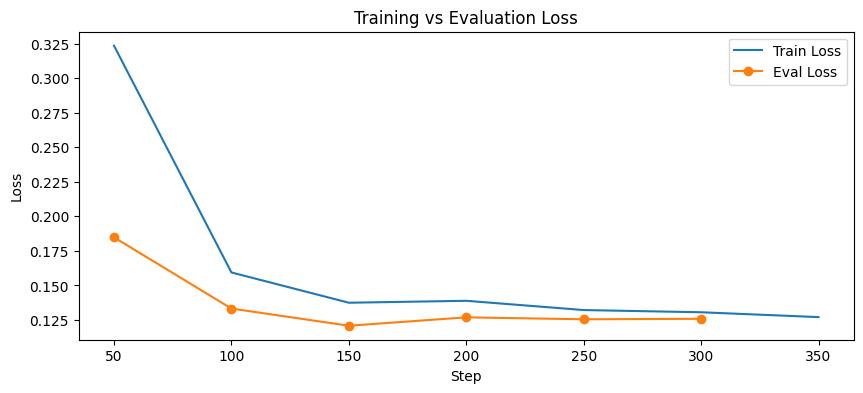

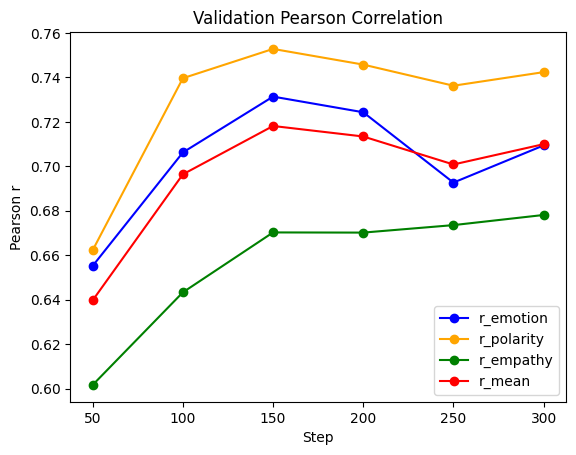

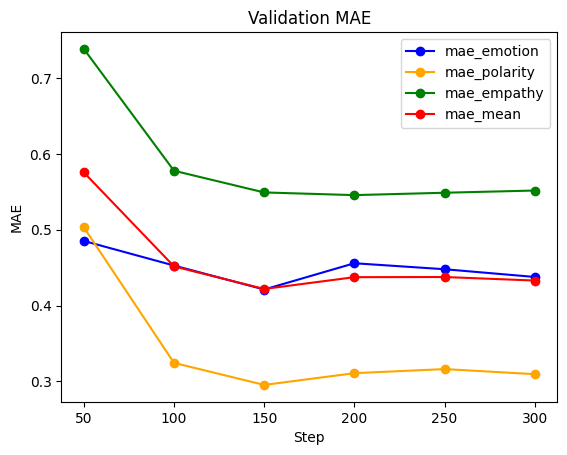

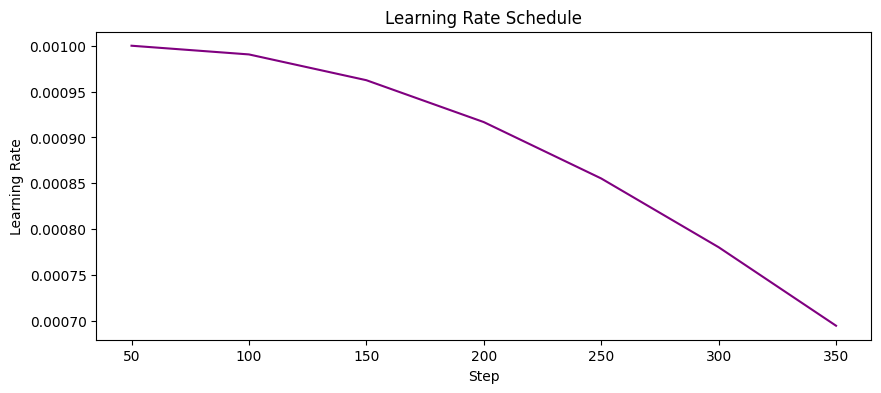

In [24]:
import matplotlib.pyplot as plt
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator

log_path = "/kaggle/working/tb_logs/events.out.tfevents.1756316303.5a98bc578558.36.0"
ea = EventAccumulator(log_path)
ea.Reload()

def get_scalars(tag):
    events = ea.Scalars(tag)
    steps = [e.step for e in events]
    values = [e.value for e in events]
    return steps, values

# ---- 1. Training & Evaluation Loss ----
train_steps, train_loss = get_scalars("train/loss")
eval_steps, eval_loss = get_scalars("eval/loss")

plt.figure(figsize=(10,4))
plt.plot(train_steps, train_loss, label="Train Loss")
plt.plot(eval_steps, eval_loss, label="Eval Loss", marker="o")
plt.xlabel("Step"); plt.ylabel("Loss")
plt.title("Training vs Evaluation Loss")
plt.legend(); plt.show()

# ---- 2. Pearson r (per label + mean) ----
for tag, color in zip(
    ["eval/r_emotion", "eval/r_polarity", "eval/r_empathy", "eval/r_mean"],
    ["blue", "orange", "green", "red"]
):
    steps, vals = get_scalars(tag)
    plt.plot(steps, vals, marker="o", label=tag.split("/")[-1], color=color)

plt.xlabel("Step"); plt.ylabel("Pearson r")
plt.title("Validation Pearson Correlation")
plt.legend(); plt.show()

# ---- 3. MAE (per label + mean) ----
for tag, color in zip(
    ["eval/mae_emotion", "eval/mae_polarity", "eval/mae_empathy", "eval/mae_mean"],
    ["blue", "orange", "green", "red"]
):
    steps, vals = get_scalars(tag)
    plt.plot(steps, vals, marker="o", label=tag.split("/")[-1], color=color)

plt.xlabel("Step"); plt.ylabel("MAE")
plt.title("Validation MAE")
plt.legend(); plt.show()

# ---- 4. Learning rate ----
steps, vals = get_scalars("train/learning_rate")
plt.figure(figsize=(10,4))
plt.plot(steps, vals, color="purple")
plt.xlabel("Step"); plt.ylabel("Learning Rate")
plt.title("Learning Rate Schedule")
plt.show()


In [25]:
from copy import deepcopy

merged_repo = "miladsolo/roberta-lora-wassa-empathy"  
merged = model.merge_and_unload()  

merged.config.problem_type = "regression"
merged.config.num_labels = 3
merged.config.id2label = {0: "Emotion", 1: "EmotionalPolarity", 2: "Empathy"}
merged.config.label2id = {"Emotion": 0, "EmotionalPolarity": 1, "Empathy": 2}
merged.push_to_hub(merged_repo, private=True)
tok.push_to_hub(merged_repo, private=True)
print(f"✅ Merged model pushed to https://huggingface.co/{merged_repo}")


Processing Files (0 / 0)                : |          |  0.00B /  0.00B            

New Data Upload                         : |          |  0.00B /  0.00B            

  /tmp/tmp5vqu3urh/model.safetensors    :   7%|6         | 33.5MB /  499MB            

README.md:   0%|          | 0.00/5.17k [00:00<?, ?B/s]

✅ Merged model pushed to https://huggingface.co/miladsolo/roberta-lora-wassa-empathy


In [28]:
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification

merged_repo = "miladsolo/roberta-lora-wassa-empathy"  # your merged repo
device = "cuda" if torch.cuda.is_available() else "cpu"

tok = AutoTokenizer.from_pretrained(merged_repo)
model = AutoModelForSequenceClassification.from_pretrained(merged_repo)
model.eval().to(device)

def predict(texts, max_len=256):
    enc = tok(texts, padding=True, truncation=True, max_length=max_len, return_tensors="pt")
    enc = {k: v.to(device) for k, v in enc.items()}
    print(enc)
    with torch.no_grad():
        logits = model(**enc).logits  # [B, 3]
    arr = logits.detach().cpu().numpy()
    return [
        {"Emotion": float(a[0]), "EmotionalPolarity": float(a[1]), "Empathy": float(a[2])}
        for a in arr
    ]

print(predict(["I’m so happy for you!", "This is really hard to deal with."]))


{'input_ids': tensor([[   0,  100,   17,   27,  119,   98, 1372,   13,   47,  328,    2],
        [   0,  713,   16,  269,  543,    7,  432,   19,    4,    2,    1]],
       device='cuda:0'), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0]], device='cuda:0')}
[{'Emotion': 3.261545181274414, 'EmotionalPolarity': 0.07658835500478745, 'Empathy': 0.9395153522491455}, {'Emotion': 2.8098268508911133, 'EmotionalPolarity': 1.9894963502883911, 'Empathy': 2.8703160285949707}]


In [29]:
# Pick an example from validation
ex = ds["validation"][0]   # you can change index to try different examples
print("🔹 Example text:", ex["text"])
print("🔹 Gold labels:", {
    "Emotion": ex["Emotion"],
    "EmotionalPolarity": ex["EmotionalPolarity"],
    "Empathy": ex["Empathy"],
})

# Run prediction
pred = predict([ex["text"]])[0]
print("🔹 Model prediction:", pred)

# Try a few examples in batch
for i in range(3):
    ex = ds["validation"][i]
    pred = predict([ex["text"]])[0]
    print(f"\nText: {ex['text']}")
    print("Labels:", {
        "Emotion": ex["Emotion"],
        "EmotionalPolarity": ex["EmotionalPolarity"],
        "Empathy": ex["Empathy"],
    })
    print("Preds :", pred)


🔹 Example text: Actually, I'm just kidding.  I remember her for her actual job.  She was a very high profile Attorney General.  A lot of really big events took place in the 1990s with her involved.
🔹 Gold labels: {'Emotion': 2.3333001136779785, 'EmotionalPolarity': 0.666700005531311, 'Empathy': 1.666700005531311}
{'input_ids': tensor([[    0, 36900,     6,    38,   437,    95, 27537,     4,  1437,    38,
          2145,    69,    13,    69,  3031,   633,     4,  1437,   264,    21,
            10,   182,   239,  4392,  2745,  1292,     4,  1437,    83,   319,
             9,   269,   380,  1061,   362,   317,    11,     5,  4525,    29,
            19,    69,   963,     4,     2]], device='cuda:0'), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]],
       device='cuda:0')}
🔹 Model prediction: {'Emotion': 2.169511318206787, 'EmotionalPolarity': 1.0847195386886597, '